参考：
- http://aidiary.hatenablog.com/entry/20180304/1520172429
- https://github.com/cross32768/VGAN/blob/master/VGAN.ipynb

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from time import sleep
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1x28x28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # -> 64x14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- VDB
        self.conv_mean = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        self.conv_logvar = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        # --------------------------------
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- VDB
        mean = self.conv_mean(x).view(-1, 128 * 7 * 7) # mean
        logvar = self.conv_logvar(x).view(-1, 128 * 7 * 7) # logvar
        noise = torch.randn(mean.size(), device=device)
        z = (0.5 * logvar).exp() * noise + mean
        # --------------------------------
        
        x = self.fc(z)
        return x, mean, logvar

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter):

    y_real = torch.ones(batch_size, 1)
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        D.train()
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)
        
        # ----------------------------------------------------------------
        # Discriminator update
        # ----------------------------------------------------------------
        D_optimizer.zero_grad()

        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetach?
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- VDB
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- 
        
        # ----------------------------------------------------------------
        # Generator update
        # ----------------------------------------------------------------
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        
        D_fake, mean, logvar = D(fake_images)
        G_loss = G_criterion(D_fake, y_real)
        
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        # ----------------------------------------------------------------
        # TensorBoardX
        # ----------------------------------------------------------------
        writer.add_scalar('train_G_loss', G_loss.item(), num_iter)
        writer.add_scalar('train_D_loss', D_loss.item(), num_iter)
        writer.add_scalar('beta', beta, num_iter)
        if num_iter % 50 == 0:
            G.eval()
            sample_z = torch.rand((64, z_dim)).to(device)
            with torch.no_grad():
                sample = G(sample_z).to('cpu')
            writer.add_image('Image_from_latent', make_grid(sample, nrow=8, padding=1), num_iter)
        num_iter += 1
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, num_iter, beta

In [6]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [7]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs/vgan-mnist'

In [8]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

(-0.5, 145.5, 145.5, -0.5)

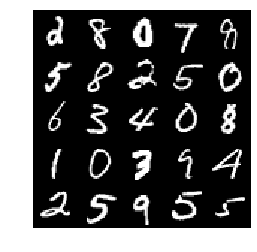

In [9]:
images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
plt.imshow(np.transpose(make_grid(images, nrow=5, padding=1).numpy(),(1, 2, 0)))
plt.axis('off')

In [10]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- VDB
I_c = 0.1
beta = 0 #1.0
alpha = 1e-5

def VDB_loss(out, label, mean, logvar, beta):
    normal_D_loss = torch.mean(F.binary_cross_entropy(out, label))
    
    kldiv_loss = - 0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
# --------------------------------

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

In [11]:
writer = SummaryWriter()

history = {}
history['D_loss'] = []
history['G_loss'] = []
num_iter = 0

for epoch in range(num_epochs):
    D_loss, G_loss, num_iter, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # save
    generate(epoch + 1, G, log_dir)
    torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
    torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))
    sleep(0.5) # for tqdm(?)

100%|██████████| 468/468 [00:23<00:00, 19.58it/s]


epoch 1, D_loss: 1.3888 G_loss: 0.6944


100%|██████████| 468/468 [00:23<00:00, 19.84it/s]


epoch 2, D_loss: 1.3869 G_loss: 0.6935


100%|██████████| 468/468 [00:23<00:00, 19.86it/s]


epoch 3, D_loss: 1.3867 G_loss: 0.6934


100%|██████████| 468/468 [00:23<00:00, 20.15it/s]


epoch 4, D_loss: 1.3865 G_loss: 0.6932


100%|██████████| 468/468 [00:23<00:00, 20.18it/s]


epoch 5, D_loss: 1.3865 G_loss: 0.6933


100%|██████████| 468/468 [00:23<00:00, 20.12it/s]


epoch 6, D_loss: 1.3865 G_loss: 0.6933


100%|██████████| 468/468 [00:23<00:00, 20.17it/s]


epoch 7, D_loss: 1.3865 G_loss: 0.6932


100%|██████████| 468/468 [00:23<00:00, 20.15it/s]


epoch 8, D_loss: 1.3865 G_loss: 0.6932


100%|██████████| 468/468 [00:23<00:00, 20.07it/s]


epoch 9, D_loss: 1.3864 G_loss: 0.6933


100%|██████████| 468/468 [00:23<00:00, 20.11it/s]


epoch 10, D_loss: 1.3847 G_loss: 0.6945


100%|██████████| 468/468 [00:23<00:00, 20.13it/s]


epoch 11, D_loss: 1.3761 G_loss: 0.7018


100%|██████████| 468/468 [00:23<00:00, 20.15it/s]


epoch 12, D_loss: 1.2497 G_loss: 0.8196


100%|██████████| 468/468 [00:23<00:00, 20.27it/s]


epoch 13, D_loss: 1.1184 G_loss: 0.9969


100%|██████████| 468/468 [00:23<00:00, 20.12it/s]


epoch 14, D_loss: 1.0765 G_loss: 1.0766


100%|██████████| 468/468 [00:23<00:00, 20.25it/s]


epoch 15, D_loss: 1.0669 G_loss: 1.1121


100%|██████████| 468/468 [00:23<00:00, 20.20it/s]


epoch 16, D_loss: 1.0574 G_loss: 1.1345


100%|██████████| 468/468 [00:23<00:00, 20.18it/s]


epoch 17, D_loss: 1.0616 G_loss: 1.1452


100%|██████████| 468/468 [00:23<00:00, 20.23it/s]


epoch 18, D_loss: 1.0560 G_loss: 1.1552


100%|██████████| 468/468 [00:23<00:00, 20.22it/s]


epoch 19, D_loss: 1.0506 G_loss: 1.1814


100%|██████████| 468/468 [00:23<00:00, 20.04it/s]


epoch 20, D_loss: 1.0482 G_loss: 1.2045


100%|██████████| 468/468 [00:23<00:00, 20.12it/s]


epoch 21, D_loss: 1.0455 G_loss: 1.2053


100%|██████████| 468/468 [00:23<00:00, 20.19it/s]


epoch 22, D_loss: 1.0408 G_loss: 1.2157


100%|██████████| 468/468 [00:23<00:00, 20.17it/s]


epoch 23, D_loss: 1.0425 G_loss: 1.2293


100%|██████████| 468/468 [00:23<00:00, 20.21it/s]


epoch 24, D_loss: 1.0476 G_loss: 1.2295


100%|██████████| 468/468 [00:23<00:00, 20.19it/s]


epoch 25, D_loss: 1.0386 G_loss: 1.2353


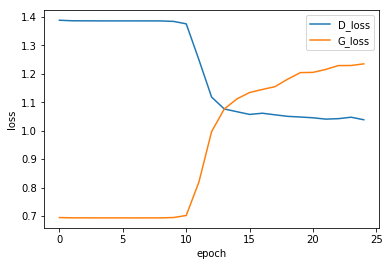

In [12]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

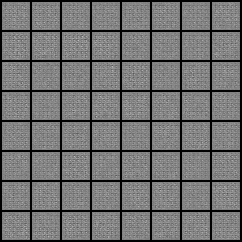

In [14]:
from IPython.display import Image
Image('logs/vgan-mnist/epoch_001.png')

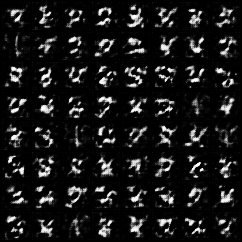

In [17]:
Image('logs/vgan-mnist/epoch_010.png')

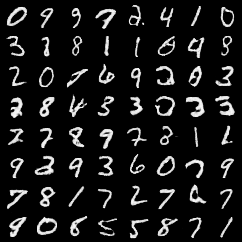

In [18]:
Image('logs/vgan-mnist/epoch_025.png')